In [32]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [33]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

KeyboardInterrupt: 

### Change later : Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [ ]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000). Non recorded data has value `-999`. 

## Machine learning

In [ ]:
from implementations import *

### Data pre-processing 

In [ ]:
# putting the meaningless values to the median of the column
tX = np.where(tX==-999., np.nan,tX)
med_X = np.nanmedian(tX, axis=0)

inds = np.where(np.isnan(tX))
tX[inds] = np.take(med_X, inds[1])

In [ ]:
print(np.where(tX[0] == 2))

In [34]:
# remove categorical data and standarize the rest
tX = np.delete(tX, 22, axis=1)
tX = np.apply_along_axis(standardize, 1, tX)

y = y[0:1000]
tX = tX[0:1000, :]

### Exploratory analysis

### Feature processing

**Least squares**

In [35]:
(w_ls, loss_ls) = least_squares(y, tX)

print("w* ={w}\n\nmse={loss}".format(
    w=w_ls, loss=loss_ls))

w* =[ -5.65912912  -6.23116017  -6.48794644  -5.55476319 -36.32470225
  -5.52714357  -5.70728379  20.1302534   -5.88010376   7.47810968
 -25.70794743  -0.63689612  39.88870704 -18.27891225  -7.73127314
  -4.09198738 -17.94186296  -6.84398193  -5.53816241  -5.54768473
  -6.02634046  -5.87041793  -4.93772415  -7.23259532  -4.86937057
  -5.66261279 -19.06710762]

mse=0.33013352021604014


**Least squares with Gradient Descent**

In [36]:
#define parameters

initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_gd = []
ws_gd = []
for gamma in gammas:
    (w, loss) = least_squares_GD(y, tX, initial_w, max_iters, gamma)
    losses_gd.append(loss)
    ws_gd.append(w)

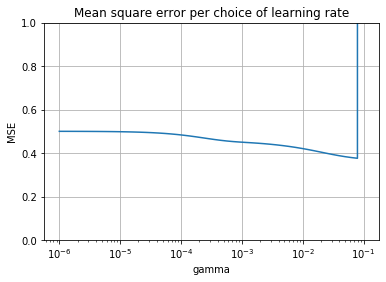

In [37]:
#plot the losses per gamma

fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [38]:
idx = np.argmin(losses_gd)

loss_gd = losses_gd[idx]
w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=loss_gd, gamma=gamma_gd ))

w* =[ 0.07345689 -0.51916826 -0.06966236  0.20054614  0.02709517  0.03213442
  0.02660758  0.03184591 -0.06319146  0.05221035  0.01627244  0.04883021
  0.03133109  0.2768451   0.02199828  0.04001589 -0.09399792  0.02299956
  0.02912634 -0.03550586  0.025114   -0.0723759   0.03267941 -0.12829756
  0.03123774  0.03115222 -0.06929939]

mse=0.37583816177722756

gamma=0.07906043210907701


**Least squares with Stochastic Gradient Descent**

In [39]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_sgd = []
ws_sgd = []
for gamma in gammas:
    (w, loss) = least_squares_SGD(y, tX, initial_w, max_iters, gamma)
    losses_sgd.append(loss)
    ws_sgd.append(w)

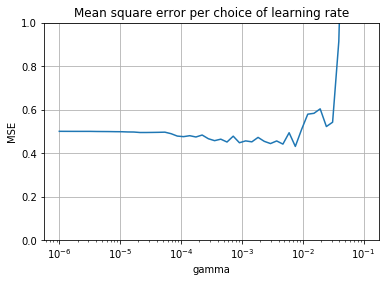

In [40]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [41]:
idx = np.argmin(losses_sgd)

loss_sgd = losses_sgd[idx]
w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_sgd, loss=loss_sgd, gamma=gamma_sgd ))

w* =[-0.01702796 -0.09803285 -0.03462625  0.06075197  0.01056903 -0.02296442
  0.00953585  0.00971091 -0.00724374  0.01502559  0.00839067  0.01396769
  0.011047    0.04188223  0.00976984  0.01084195 -0.02314668  0.00959979
  0.0131432   0.0213073   0.00979498 -0.06768881  0.00809746 -0.03488257
  0.01202611  0.01180358  0.01834813]

mse=0.43039573179104407

gamma=0.007543120063354623


**Ridge regression**

***Cross-validation hyperparameter selection***

In [42]:
def cross_validation_visualization(lambds, loss_tr, loss_te):
    """visualization the curves of train error and test error."""
    plt.semilogx(lambds, loss_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, loss_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("error")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)

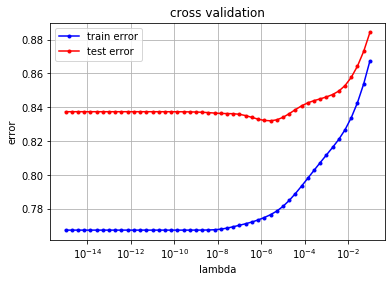

In [43]:
seed = 1
degree = 2
k_fold = 4
lambdas = np.logspace(-15, -1, 50)

k_indices = build_k_indices(y, k_fold, seed)
rmse_tr_cv = []
rmse_te_cv = []

for lambda_ in  lambdas:
    l_rmse_tr = []
    l_rmse_te = []
    for k in range(k_fold):
        loss_tr, loss_te = cross_validation(y, tX, k_indices, k, lambda_, degree)
        l_rmse_tr.append(np.sqrt(2*loss_tr))
        l_rmse_te.append(np.sqrt(2*loss_te))
    rmse_tr_cv.append(np.mean(l_rmse_tr))
    rmse_te_cv.append(np.mean(l_rmse_te))
cross_validation_visualization(lambdas, rmse_tr_cv, rmse_te_cv)

In [44]:
idx = np.argmin(rmse_te_cv)
lambda_ri = lambdas[idx]

print("lambda* ={lambda_}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, rmse_tr=rmse_tr_cv[idx], rmse_te=rmse_te_cv[idx]))

lambda* =2.6826957952797274e-06

rmse train=0.776555000977562

rmse test=0.8320136662905072


***Bias-variance decomposition for complexity determination***

In [45]:
def bias_variance_decomposition_visualization(degrees, loss_tr, loss_te):
    """visualize the bias variance decomposition."""
    loss_tr_mean = np.expand_dims(np.mean(loss_tr, axis=0), axis=0)
    loss_te_mean = np.expand_dims(np.mean(loss_te, axis=0), axis=0)
    plt.plot(degrees, loss_tr.T, 'b', linestyle="-", label='train', linewidth=0.3)
    plt.plot(degrees, loss_te.T, 'r', linestyle="-", label='test', linewidth=0.3)
    plt.plot(degrees, loss_tr_mean.T, 'b', linestyle="-", label='train', linewidth=3)
    plt.plot(degrees, loss_te_mean.T, 'r', linestyle="-", label='test', linewidth=3)
    plt.ylim(0, 5)
    plt.xlabel("degree")
    plt.ylabel("error")
    plt.title("Bias-Variance Decomposition")

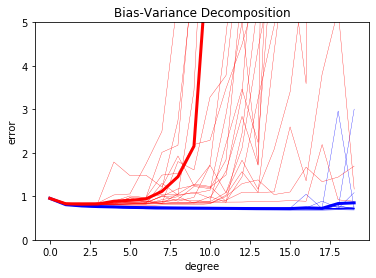

In [46]:
seeds = range(20)
ratio_train = 0.7
degrees = range(0, 20)

rmse_tr_bv = np.empty((len(seeds), len(degrees)))
rmse_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)        
        
    mse_tr = []
    mse_te = []
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
            
        w_tr, mse_tr = ridge_regression(y_tr, tx_tr, lambda_ri)
        mse_te = compute_mse(y_te, tx_te, w_tr)
            
        rmse_tr_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_tr))
        rmse_te_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_te))

bias_variance_decomposition_visualization(degrees, rmse_tr_bv, rmse_te_bv)

In [47]:
rmse_te_bv = np.array(rmse_te_bv)
rmse_tr_bv = np.array(rmse_tr_bv)

idx = np.argmin(np.mean(rmse_te_bv-rmse_tr_bv, axis=1))

degree_ri = degrees[idx]

print("degree* ={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    degree=degree_ri, rmse_tr=rmse_tr_bv[idx].mean(), rmse_te=rmse_te_bv[idx].mean()))

degree* =15

rmse train=0.7453440025209879

rmse test=0.931126237243878


**Logistic regression**

In [48]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_lr = []
ws_lr = []
for gamma in gammas:
    (w, loss) = logistic_regression(y, tX, initial_w, max_iters, gamma)
    losses_lr.append(loss)
    ws_lr.append(w)

C:\Users\Christelle\Documents\EPFL\MA1\Machine learning\Group works\Machine-learning-Project-2019\scripts\implementations.py:54: RuntimeWarning: divide by zero encountered in log
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))


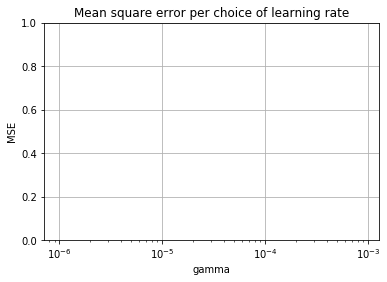

In [49]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_lr)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [50]:
idx = np.argmin(losses_lr)

loss_lr = losses_lr[idx]
w_lr = ws_lr[idx]
gamma_lr = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=ws_lr, loss=loss_lr, gamma = gamma_lr))

w* =[array([-0.07829367, -0.02982142, -0.04241586,  0.00617647,  0.03631525,
       -0.19044639,  0.03860661,  0.03595541,  0.02082805, -0.07814741,
        0.03676544,  0.03920417,  0.03803192,  0.0077586 ,  0.03843742,
        0.03848478, -0.00812753,  0.03838206,  0.03835875,  0.00072957,
        0.03852587, -0.12766504,  0.03850146, -0.01230001,  0.03848512,
        0.03850485, -0.00083447]), array([-0.09429878, -0.03700688, -0.05120809,  0.00794682,  0.04367284,
       -0.2289525 ,  0.0464258 ,  0.04324058,  0.02497842, -0.09350561,
        0.04419808,  0.04717903,  0.04574129,  0.00962591,  0.04622251,
        0.04629179, -0.01000862,  0.04615633,  0.04613197,  0.00067725,
        0.04633268, -0.15319336,  0.04630714, -0.01496882,  0.04628614,
        0.04631012, -0.00058203]), array([-1.12955966e-01, -4.58644485e-02, -6.15127694e-02,  1.02458324e-02,
        5.22148033e-02, -2.73671372e-01,  5.55034464e-02,  5.16987159e-02,
        2.97677291e-02, -1.11102089e-01,  5.28203674e-0

**Regularized logistic regression**

In [51]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_rlr = []
ws_rlr = []
for gamma in gammas:
    (w, loss) = reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma)
    losses_rlr.append(loss)
    ws_rlr.append(w)

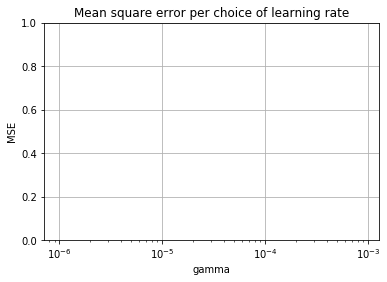

In [52]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_rlr)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [53]:
idx = np.argmin(losses_rlr)

loss_rlr = losses_rlr[idx]
w_rlr = ws_rlr[idx]
gamma_rlr = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=ws_rlr, loss=loss_rlr, gamma = gamma_rlr))

w* =[array([-0.07829367, -0.02982142, -0.04241586,  0.00617647,  0.03631525,
       -0.19044639,  0.03860661,  0.03595541,  0.02082805, -0.07814741,
        0.03676544,  0.03920417,  0.03803192,  0.0077586 ,  0.03843742,
        0.03848478, -0.00812753,  0.03838206,  0.03835875,  0.00072957,
        0.03852587, -0.12766504,  0.03850146, -0.01230001,  0.03848512,
        0.03850485, -0.00083447]), array([-0.09429878, -0.03700688, -0.05120809,  0.00794682,  0.04367283,
       -0.2289525 ,  0.0464258 ,  0.04324058,  0.02497842, -0.09350561,
        0.04419807,  0.04717903,  0.04574128,  0.00962591,  0.04622251,
        0.04629179, -0.01000862,  0.04615633,  0.04613197,  0.00067725,
        0.04633268, -0.15319336,  0.04630714, -0.01496882,  0.04628614,
        0.04631012, -0.00058203]), array([-1.12955965e-01, -4.58644482e-02, -6.15127690e-02,  1.02458324e-02,
        5.22148029e-02, -2.73671370e-01,  5.55034460e-02,  5.16987155e-02,
        2.97677289e-02, -1.11102088e-01,  5.28203670e-0

***Cross-validation hyperparameter selection***

In [54]:
seed = 1
degree = 2
k_fold = 4
lambdas = np.logspace(-15, -1, 50)

k_indices = build_k_indices(y, k_fold, seed)

log_tr_rlr = []
log_te_rlr = []

for lambda_ in  lambdas:
    l_log_tr = []
    l_log_te = []
    for k in range(k_fold):
        loss_tr, loss_te = cross_validation_log(y, tX, k_indices, k, lambda_, degree, reg_logistic_regression)
        l_log_tr.append(loss_tr)
        l_log_te.append(loss_te)
    log_tr_rlr.append(np.mean(l_log_tr))
    log_te_rlr.append(np.mean(l_log_te))
cross_validation_visualization(lambdas, log_tr_rlr, log_te_rlr)

TypeError: cross_validation_log() takes 6 positional arguments but 7 were given

### Overfitting vs Underfitting

### Methods application and visualization

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)